In [242]:
#def process_gcn(payload, root):
#    if root.attrib['role'] != 'observation':
#        return

    # Read all of the VOEvent parameters from the "What" section.
#    params = {elem.attrib['name']:
#              elem.attrib['value']
#              for elem in root.iterfind('.//Param')}

#put into script to allow autorun

In [243]:
from astropy.io import fits
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value, FlatLambdaCDM
import urllib
import healpy as hp
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time 
import multiprocessing as mp
import datetime as datetime
#import gcn

In [244]:
import time
start_time = time.time()
url='http://skyserver.sdss.org/dr15/en/tools/search/x_results.aspx?searchtool=SQL&'
file = 'bayestar.fits.gz'

In [245]:
prob, distmu, distsigma, distnorm = hp.read_map(file, field = [0,1,2,3])
#hpy = hp.read_map('../bayestar.fits.gz')

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


In [246]:
hdul = fits.open(file)
t = hdul[1].header['OBJECT']
t

'G354219'

In [247]:
r = np.linspace(0,7000,num=1000)

def distance(rr, pixel):
    return distnorm[pixel]/(np.sqrt(2*np.pi)*distsigma[pixel])*np.exp(-(rr-distmu[pixel])**2 
                                                               /(2*distsigma[pixel])**2)*rr**2

In [248]:
prob1 = list(prob)
npix = len(prob)
nside = hp.npix2nside(npix)

most_probable_distance = []
ra, dec, std = [], [], []
probability = []

for pix1 in range(int(len(prob1))):
  #  if prob1[pix1] < 1e-15:
   #     continue
    dist = distance(r,pix1)
    dist = list(dist)
    inde = dist.index(np.amax(dist))
    most_probable_distance.append(inde * 7) #in units of Mpc
    theta, phi = hp.pix2ang(nside, pix1)
    ra.append(np.rad2deg(phi))
    dec.append(np.rad2deg(0.5 * np.pi - theta))
    probability.append(prob1[pix1])
    
# data1 is the same as data with duplicates removed
data,data1, z, stdz  = [], [], [], []
for i in range(int(len(probability))):
    if dec[i] > -10:
        data.append([probability[i] ,most_probable_distance[i],int(ra[i]), int(dec[i]), distsigma[i]])
    elif dec[i] < -10:
        prob[i] -= np.max(prob)
    
data = sorted(data, key=lambda data: data[0]) #sort all data by the probability of the object
# being found in the ra and dec defined by that pixel
    
for i in range(int(len(data))):
    coor = SkyCoord(ra = int(ra[i])*u.degree, dec = int(dec[i])*u.degree, frame='icrs')
    coorg = coor.galactic
    if coorg.b.degree > 20 or coorg.b.degree <(-20):
        if data[i][3]!=data[i-1][3] and data[i][2]!=data[i-1][2]:
            data1.append([probability[i] ,most_probable_distance[i],int(ra[i]), int(dec[i]), distsigma[i]])
    else:
        prob[i] -= np.max(prob) 
            #only has some pixels because of efficiency increase that removes all ra and dec that are the 
            #same with a rounding to nearest ra and dec

            
for i in range(1000):
    if data1[i][1] > 0.001:
        z.append(z_at_value(Planck13.luminosity_distance,data1[i][1]*u.Mpc)) #calculate the redshift
        stdz.append(z_at_value(Planck13.luminosity_distance,data1[i][4]*u.Mpc ) )

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


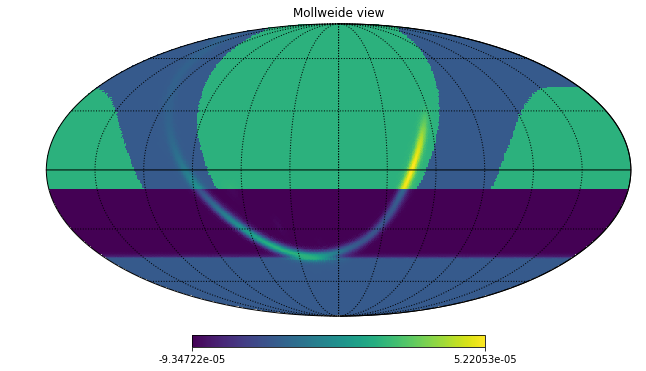

<Figure size 432x288 with 0 Axes>

In [249]:
hp.mollview(prob, rot=180)
hp.graticule()
plt.show();
plt.savefig(str(t) + '.png');

In [250]:
prob1 = list(prob)
npix = len(prob)
nside = hp.npix2nside(npix)

In [251]:
ipix = prob1.index(np.amax(prob1))
theta, phi = hp.pix2ang(nside, ipix)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)
ra, dec

(135.17578125, -0.895282986570128)

Find the most probable distance of each pixel and the ra and dec for that pixel

Append all data needed for an sql to a list and sort it so highest probability is at the top

Excludes data that is unobservable to us

In [252]:

data_for_telescope = []
for i in range(len(z)):
    sql = 'SELECT sp.objid,sp.ra,sp.dec, sp.class, sp.z as redshift, ISNULL(m.k,0) as k , sp.dered_r FROM SpecPhoto AS sp JOIN apogeeOBJECT AS m ON sp.dec = m.dec WHERE sp.z >' + str(z[i] - 5* stdz[i]) + ' AND sp.z < ' + str(z[i] + 5* stdz[i]) + ' AND sp.class = "GALAXY" AND sp.ra > ' + str(data[i][2] - 1) + ' AND sp.ra < ' + str(data[i][2] + 1) + ' AND sp.dec > '+ str(data[i][3] - 1) + ' AND sp.dec <' + str(data[i][3] + 1)
    #performs sql for most probable sky locations
    params = urllib.parse.urlencode({'cmd': sql, 'format': 'fits'}) #open the connection and run the sql
    urllib.request.urlretrieve(url+params, 'gt1.fits'); #collect and save the data
    hud = fits.open('gt1.fits', ignore_missing_end=True) # read the file the data was output to
    if len(hud) == 1:
        continue
    else:
        galaxies = (np.array(hud[1].data))
        sql1 = sql
        for j in range(len(galaxies)):
            theta = 0.5 * np.pi - np.deg2rad(galaxies[j][2])
            phi = np.deg2rad(galaxies[j][1])
            pix = hp.ang2pix(nside, theta, phi)
            d = Planck13.luminosity_distance(galaxies[j][4])
            prob_of_gal = distance((d.value), pix)
            data_for_telescope.append([galaxies[j][0], galaxies[j][1], galaxies[j][2], galaxies[j][4]
                                           , d.value, prob_of_gal, galaxies[j][5], galaxies[j][6]])


#print("--- %s seconds ---" % (time.time() - start_time))

In [253]:
data_for_telescope = sorted(data_for_telescope, key=lambda l: sum(l))
data_tele = []
ID = []
for i in range(len(data_for_telescope)):
    ID.append(data_for_telescope[i][0])
for i in range(len(data_for_telescope)):
    if ID[i] not in ID[0:i-1] and ID[i] not in ID[i+1:len(ID)-1]:
        data_tele.append(data_for_telescope[i])
data_tele = sorted(data_tele, key=lambda data_tele: data_tele[5], reverse=True)
#print("--- %s seconds ---" % (time.time() - start_time))

In [254]:
mt_stony_brook = EarthLocation(lat=40.91457*u.deg, lon=286.87453*u.deg, height=48*u.m)

In [255]:
def find_alt(count):
    
    lst, obstime1 = [], []
    
    ra = data_tele[count][1]*u.degree
    dec = data_tele[count][2]*u.degree
    from astropy.coordinates import SkyCoord, EarthLocation, AltAz
    coordinates = SkyCoord(ra,dec, frame='icrs')  

    for change in range(24):
        time =  datetime.datetime.now() + datetime.timedelta(hours=change)
        obstime1.append(time.hour-5)    
        AltAzi = coordinates.transform_to(AltAz(obstime=time, location=mt_stony_brook))
        lst.append(AltAzi.alt)

    return lst, obstime1


In [256]:
exp_time, obstime1, altitude_time = [], [], [], 
for i in range(len(data_tele)):
    M_object = -15.8
    mag_source = M_object + 25 + 5*np.log10(data_tele[i][3])
    M = 16.2
    x = (mag_source - M) / 2.5
    exp_time.append(30*(10**x)**2) 
    pool = mp.Pool(mp.cpu_count())
    altitude_time1 = pool.map(find_alt, [data for data in range(1)])
    pool.close()
    altitude_time.append(altitude_time1)
#    altitude_time.reshape
 #   alt.append(altitude_time[][])
  #  time.append(altitude_time[][])

In [285]:
ra, dec, ra_rad, dec_rad = [], [], [], []
length = len(data_tele)
for i in range(len(data_tele)):
    ra.append(data_tele[i][1])
    dec.append(data_tele[i][2])
    ra_rad.append(data_tele[i][1] * np.pi / 180)
    dec_rad.append(data_tele[i][2] * np.pi / 180)
gamma_max = .25 * np.pi / 180


for i in range(length):    
    for j in range(i, length-1):
        gamma = np.sqrt(((ra_rad[i]-ra_rad[j]) * np.cos(dec_rad[i]))**2 + (dec_rad[i]-dec_rad[j])**2)
        if gamma < gamma_max:
            ra_mix = (ra[i] + ra[j])/2
            dec_mix = (dec[i] + dec[j])/2
            prob_mix = data_tele[i][5] + data_tele[j][5]
            z_mix = max(data_tele[i][3], data_tele[j][3])
            d_mix = max(data_tele[i][4], data_tele[j][4])
            ID_mix = 'mix'
            data_tele.append([ID_mix, ra_mix, dec_mix, z_mix, d_mix, prob_mix,0,0])

IndexError: list index out of range

In [286]:
len(data_tele), len(dec_rad)

(140, 112)

In [ ]:
rise_time, set_time = []
for j in range(int(len(data_tele))):
    alt = []
    time = []
    for i in range(len(altitude_time[0][0][0])):
        alt.append(altitude_time[j][0][0][i].value)
        time.append(altitude_time[j][0][1][i])
        k = alt.index(np.amin(alt))
        j = alt.index(np.amax(alt))
    for timey in range(k,len(alt)):
        if alt[timey] > 40:
            rise_time.append(time[timey])
            break  
        elif timey == len(alt)-1:
            for timey1 in range(k):
                if alt[timey1] > 40:
                    rise_time.append(time[timey1])
                    break 
    for timey in range(j,len(alt)):
        if alt[timey] > 40:
            set_time.append(time[timey])
            break  
        elif timey == len(alt)-1:
            for timey1 in range(j):
                if alt[timey1] > 40:
                    set_time.append(time[timey1])
                    break 

## Need to do: 
#####    4) figure out where i can look at multiple galaxies


In [287]:
import pandas as pd
Telescope = pd.DataFrame(data_tele)
Telescope.columns=['ID', 'RA', 'Dec', 'Redshift', 'Distance (MPC)', 'Probability', 'k_mag', 'r']

Telescope['Exposure Time'] = exp_time

Telescope['Rise Time'] = rise_time
Telescope['Set Time']  = set_time

Telescope['Mass M_odot'] = 10**(-.4 * Telescope['k_mag'] + 
                         17.45 + 1.22 * Telescope['Redshift'] - .25*Telescope['Redshift']**2)

Telescope['Prob_mass'] = Telescope['Mass M_odot'] * Telescope['Probability']
#Telescope.sort_values(by=('Prob_mass'), ascending = False)
Telescope.sort_values(by=['Probability', 'Observation Time'], ascending = False)
Telescope

ValueError: Length of values does not match length of index

In [288]:
Telescope.to_csv(t + '_prob', sep=' ')

In [235]:
np.mean(most_probable_distance)

1354.0065930684407

In [236]:
M_object = -15.8
mag_source = M_object + 25 + np.log10(Planck13.luminosity_distance(data_tele[0][4])/(1*u.Mpc))
M = 7.67
x = (mag_source - M) / 2.5
exp_time = 1.6*10**x

In [237]:
np.max(exp_time)/3600

<Quantity 2.7630105>

In [238]:
np.mean(Telescope['Distance (MPC)'])

2775.4672059879053

In [239]:
most_probable_distance[1]

371

In [240]:
np.min(Telescope['k_mag'])

9.722999572753906

### time of day things
### see if I can view two galaxies at once

In [291]:
import multiprocessing as mp
data_tele

[[1237651715871016100,
  247.72452999999996,
  49.157131,
  0.94904786,
  6366.49510114473,
  0.0002006787671477162,
  15.315,
  22.345602],
 [1237665571440493779,
  249.65479000000005,
  50.907005,
  0.9506083,
  6379.392733416625,
  0.00019925209633772967,
  15.063,
  22.071932],
 [1237665570903753966,
  249.226,
  50.55814,
  0.9458178,
  6339.814625497236,
  0.00019882586331175414,
  14.786,
  21.718843],
 [1237665569293206216,
  247.78183,
  49.706192,
  0.8591175,
  5632.431219057064,
  0.00014693757773766124,
  14.255,
  21.837446],
 [1237662701865075744,
  248.65624000000003,
  50.775177,
  0.85186344,
  5574.040265467713,
  0.00014260371116721205,
  14.433,
  21.750738],
 [1237662701328073593,
  248.03755999999998,
  50.795811,
  0.76584464,
  4891.645229738053,
  0.00010537724206588993,
  13.477,
  21.934155],
 [1237651715334144131,
  247.28040999999996,
  49.025837,
  0.74767506,
  4749.967956708027,
  8.58097803123081e-05,
  13.577,
  20.395884],
 [1237665570366817615,
  24